# Homework 2 - Montero, Peterssen, Brousse

In [83]:
from bs4 import BeautifulSoup
import requests
import re
import numpy as np
import pandas as pd

## Fetching all students enrolled in CS in Bachelor from 2007 to 2017

In [84]:
# Base url of isa
base_url = "http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS"

## Part 1 - Fetch from ISA all codes used as parameters for fetching data

In [85]:
# Get all parameters from the ISA form
select_url = base_url +  ".filter?"
select_params = {'ww_i_reportModel' : '133685247'}

r  = requests.get(select_url, params=select_params)
data = r.text
soup = BeautifulSoup(data, "lxml")
allCodes = {}

# For each dropdown on the form get the corresponding codes
for dropdown in soup.find_all('select'):
   key = dropdown.get('name')
   codes = dict([(option.text, option.get('value')) for option in dropdown.find_all('option') if option.text])
   allCodes[key] = codes

# Dictionary with all the codes
allCodes

{'ww_x_HIVERETE': {"Semestre d'automne": '2936286',
  'Semestre de printemps': '2936295'},
 'ww_x_PERIODE_ACAD': {'2007-2008': '978181',
  '2008-2009': '978187',
  '2009-2010': '978195',
  '2010-2011': '39486325',
  '2011-2012': '123455150',
  '2012-2013': '123456101',
  '2013-2014': '213637754',
  '2014-2015': '213637922',
  '2015-2016': '213638028',
  '2016-2017': '355925344'},
 'ww_x_PERIODE_PEDAGO': {'Bachelor semestre 1': '249108',
  'Bachelor semestre 2': '249114',
  'Bachelor semestre 3': '942155',
  'Bachelor semestre 4': '942163',
  'Bachelor semestre 5': '942120',
  'Bachelor semestre 5b': '2226768',
  'Bachelor semestre 6': '942175',
  'Bachelor semestre 6b': '2226785',
  'Master semestre 1': '2230106',
  'Master semestre 2': '942192',
  'Master semestre 3': '2230128',
  'Master semestre 4': '2230140',
  'Mineur semestre 1': '2335667',
  'Mineur semestre 2': '2335676',
  'Mise à niveau': '2063602308',
  'Projet Master automne': '249127',
  'Projet Master printemps': '3781783

In [86]:
def fetch_data (url, args) :
    '''GETs a webpage, determined by its url, and optional parameters.
       Returns a BeautifulSoup containing the parsed HTML page. '''
    req = requests.get(url, params=args)
    if req.status_code != requests.codes.ok:
        print('Error: code ' + str(req.status_code))
        return None
    
    return BeautifulSoup(req.text, 'html.parser')

Parse an ISA table:

In [87]:
def parse_table(soup) :
    table = soup.find("table")
    rows = table.find_all("tr")
    return rows

Define default url and constant parameter

In [88]:
data_url = base_url + ".html?"

args = {'ww_x_GPS' : '-1', 
              'ww_i_reportModel' : '133685247',
              'ww_i_reportModelXsl':'133685270',
              'ww_x_UNITE_ACAD' : 'null',
              'ww_x_PERIODE_ACAD' : 'null', 
              'ww_x_PERIODE_PEDAGO' : 'null', 
              'ww_x_HIVERETE':'null'}

args['ww_x_UNITE_ACAD'] = allCodes['ww_x_UNITE_ACAD']['Informatique']


Iterate over the years and the semesters codes, fetch and parse data, store the result in a dataFrame only considering useful columns

In [89]:
def assign_semester (period):
    if('Projet' in period) :
        semester = ['PDM', 1] if ('automne' in period) else ['PDM' , 2]
    else :
        semester = [period.split(" ")[0], int(re.findall(r'\d+', period)[0])]
   
    return semester

In [90]:
def fetch_table() :
    rn = []
    for year, y_code in allCodes['ww_x_PERIODE_ACAD'].items():
        for periode, p_code in allCodes['ww_x_PERIODE_PEDAGO'].items():
            if any(degree in periode for degree in ['Bachelor', 'Master']):
                args['ww_x_PERIODE_ACAD'] = p_code
                args['ww_x_PERIODE_PEDAGO'] = y_code

                soup = fetch_data(data_url, args)
                rows = parse_table(soup)
                
                for row in rows:
                    cell = row.find_all('td')
                    if cell:                      
                        rn.append({'title' : cell[0].get_text(),
                                   'name'     : cell[1].get_text(),
                                   'spec' : cell[4].get_text(),
                                   'minor' : cell[6].get_text(),
                                   'status' : cell[7].get_text(),
                                   'sciper' : cell[10].get_text(),
                                   'degree':  assign_semester(periode)[0],
                                   'end': year.split("-")[1],
                                   'semester':  assign_semester(periode)[1], 
                                   'start': year.split("-")[0]}) 
             
    return pd.DataFrame(data = rn)

In [91]:
data = fetch_table()

## Part 3 - Statistical analysis

In [92]:
# sort columns
data = data[['sciper', 'title', 'name', 'start', 'end', 'degree', 'semester', 'status', 'spec', 'minor']]

# 'semester' value is an integer
data.semester = data.semester.astype(int)

# index by sciper number
data = data.set_index('sciper')

data.sample(5)

,title,name,start,end,degree,semester,status,spec,minor
sciper,,,,,,,,,
250700,Monsieur,Chau Alexandre,2016,2017,Bachelor,3,Présent,,
213027,Monsieur,Devillard Florent,2014,2015,Bachelor,6,Présent,,
201568,Monsieur,Link Jonathan Stéphane Oskar,2014,2015,Bachelor,6,Présent,,
223892,Monsieur,Garret Louis-Maxence Thierry Clément Marie,2014,2015,Bachelor,4,Présent,,
262598,Monsieur,Leemann Marc Pierre,2015,2016,Bachelor,1,Présent,,


### Part 3a - Bachelor data

We're keeping only students who were both in BA1 and BA6:

In [93]:
# filter to keep only bachelor data and appropriate semesters
ba_data = data[data.degree == 'Bachelor']
ba_1 = ba_data[ba_data.semester == 1]
ba_6 = ba_data[ba_data.semester == 6]

print('There were', len(ba_1), 'students in IN-BA1 over the years')
print('There were', len(ba_6), 'students in IN-BA6 over the years')

There were 1720 students in IN-BA1 over the years
There were 664 students in IN-BA6 over the years


In [94]:
# compute the intersection by using sets
def compute_intersection_first_last_semester(df, first, last):
    intersection_index = set(first.index).intersection(set(last.index))
    intersection = df[df.index.isin(intersection_index)].sort_index()
    return intersection

Now each semester that every qualifying student has done is in the dataframe.<br>
We need to group the students by sciper and count the number of semesters.

In [95]:
def compute_semester_count(intersection):
    semester_count = intersection.reset_index()[['sciper', 'semester']].groupby(['sciper']).count()
    semester_count = semester_count.rename(columns={'semester' : 'semester_count'})
    intersection_counted = intersection.merge(semester_count, left_index=True, right_index=True)
    return intersection_counted

With use of the two defined functions, we can now get our semester count:

In [96]:
ba_counted = compute_semester_count(compute_intersection_first_last_semester(ba_data, ba_1, ba_6))
ba_counted.head(10)

,title,name,start,end,degree,semester,status,spec,minor,semester_count
sciper,,,,,,,,,,
147008,Monsieur,Good Xavier,2008,2009,Bachelor,1,Présent,,,6
147008,Monsieur,Good Xavier,2008,2009,Bachelor,2,Présent,,,6
147008,Monsieur,Good Xavier,2010,2011,Bachelor,5,Congé,,,6
147008,Monsieur,Good Xavier,2009,2010,Bachelor,4,Présent,,,6
147008,Monsieur,Good Xavier,2010,2011,Bachelor,6,Congé,,,6
147008,Monsieur,Good Xavier,2009,2010,Bachelor,3,Présent,,,6
169569,Monsieur,Arévalo Christian,2007,2008,Bachelor,1,Présent,,,6
169569,Monsieur,Arévalo Christian,2009,2010,Bachelor,5,Présent,,,6
169569,Monsieur,Arévalo Christian,2008,2009,Bachelor,4,Présent,,,6


We want to keep one row per person and drop the columns that aren't useful for the analysis.

In [97]:
ba_counted = ba_counted.groupby(ba_counted.index).agg('first')
ba_counted = ba_counted[['title', 'name', 'semester_count']]
ba_counted.head()

,title,name,semester_count
sciper,,,
147008,Monsieur,Good Xavier,6
169569,Monsieur,Arévalo Christian,6
169731,Monsieur,Knecht Mathieu,8
169795,Monsieur,Scheiben Pascal,9
171195,Monsieur,Richter Arnaud,6


We can now group by sex and compute the required stats:

In [98]:
ba_counted.groupby('title').describe()

semester_count
title                         
Madame   count       29.000000
         mean         6.793103
         std          1.346406
         min          6.000000
         25%          6.000000
         50%          6.000000
         75%          8.000000
         max         11.000000
Monsieur count      368.000000
         mean         7.105978
         std          1.536891
         min          4.000000
         25%          6.000000
         50%          6.000000
         75%          8.000000
         max         12.000000

### Discussion:

Let's split the dataset into men and women:

In [157]:
from scipy import stats
ba_men = ba_counted[ba_counted.title == 'Monsieur']['semester_count']
ba_women = ba_counted[ba_counted.title == 'Madame']['semester_count']

print('Average duration for men is (in semesters):', ba_men.mean())
print('Average duration for women is (in semesters):', ba_women.mean())

Average duration for men is (in semesters): 7.105978260869565
Average duration for women is (in semesters): 6.793103448275862


The null hypothesis we are testing against is: <b style="color:orange">H0 = "The average duration for the bachelor is the same for men and women"</b>.<br>
We will use the <b>two-sample t-test</b> for proving or disproving this hypothesis.<br>
This test assumes that the variance of the two random variables are different. We need to check this first:

In [162]:
dif_var = ba_men.var() - ba_women.var()
print('The difference in variances is', dif_var, '!= 0, so we can proceed.')

The difference in variances is 0.549227125927124 != 0, so we can proceed.


In [165]:
stats.ttest_ind(
    ba_men,
    ba_women,
    equal_var = False
)

Ttest_indResult(statistic=1.191705695448116, pvalue=0.24162457057331926)

The p-value that we find is `24.16% >> 5%`, which is the maximal acceptable value to accept H0.<br>
So we **reject** H0: the difference in average **is statistically significant**.

## Part 3b - Master data

<p>We will perform the same kind of computation as before to compute the number of semesters per student. We need to mind the fact that some students don't start in the first semester, but in the second one. Also, we need to distinguish between students with a specialization or a minor, and those without.</p>
<p><b>Assumptions:</b><br>
- Some students have a MA3 registered even though they don't do either a specialization or a minor. We will consider them anyways.<br>
</p>

In [99]:
# Proceed as before to filter into semesters
ma_data = data[data.degree == 'Master']
ma_1 = ma_data[ma_data.semester == 1]
ma_2 = ma_data[ma_data.semester == 2]
ma_3 = ma_data[ma_data.semester == 3]

print('There were', len(ma_1), 'students in IN-MA1 over the years')
print('There were', len(ma_2), 'students in IN-MA2 over the years')
print('There were', len(ma_3), 'students in IN-MA3 over the years')

There were 948 students in IN-MA1 over the years
There were 1062 students in IN-MA2 over the years
There were 706 students in IN-MA3 over the years


In the bachelor analysis, we needed to compute the semester count between the first BA1 and the last BA6.<br>
Here, it is not that simple, since the last semester of MA is not the same for everyone: some students finish in MA2, some finish in MA3, and they can very well succeed in both cases.<br>
=&gt; The problem here is then to figure out, for which student, if their last semester is MA2 or MA3. This is done with the following index:

In [100]:
last_index = ma_data.groupby(ma_data.index).agg({'semester' : np.max})

# 'semester' column here indicates the last semester number of the given student.
last_index.head(5)

,semester
sciper,
128911,3
129093,3
129326,3
138088,1
145546,3


Now, we merge this table back with all the master data. This is a typical `inner join`:

In [172]:
ma_last = ma_data.reset_index().merge(last_index.reset_index(), how='inner', on=['sciper','semester']).set_index('sciper')
ma_last.sort_index().head(5)

,title,name,start,end,degree,semester,status,spec,minor
sciper,,,,,,,,,
128911,Monsieur,Gulati Asheesh,2007,2008,Master,3,Présent,Internet computing,
129093,Monsieur,Zhou Maoan,2007,2008,Master,3,Stage,,
129326,Monsieur,Ni Zhong Zhong,2007,2008,Master,3,Présent,,
138088,Monsieur,Droz-dit-Busset Arnault,2007,2008,Master,1,Présent,,
145546,Monsieur,Clivaz Jean-Philippe,2007,2008,Master,3,Présent,,


We need to <b>not consider</b> students whose maximal semester number is 1: this would be an indication that the student did not graduate at EPFL:

In [173]:
ma_last = ma_last[ma_last.semester != 1]
ma_last.sort_index().head(5)

,title,name,start,end,degree,semester,status,spec,minor
sciper,,,,,,,,,
128911,Monsieur,Gulati Asheesh,2007,2008,Master,3,Présent,Internet computing,
129093,Monsieur,Zhou Maoan,2007,2008,Master,3,Stage,,
129326,Monsieur,Ni Zhong Zhong,2007,2008,Master,3,Présent,,
145546,Monsieur,Clivaz Jean-Philippe,2007,2008,Master,3,Présent,,
145957,Monsieur,Hügli Michael,2007,2008,Master,3,Présent,,


Now, we can use the functions that we defined in the Bachelor part, to compute the now usual intersection between students who were in the MA1 and then subsequently in their respective last semester of Master (MA2 or MA3).

In [175]:
ma_counted = compute_semester_count(compute_intersection_first_last_semester(ma_data, ma_1, ma_last))
ma_counted = ma_counted.groupby(ma_counted.index).agg('first')
ma_counted = ma_counted[['title', 'name', 'semester_count', 'minor', 'spec']]
ma_counted.sample(5)

,title,name,semester_count,minor,spec
sciper,,,,,
224356,Monsieur,Guggenheim Daniel Vincent,3,,
205617,Monsieur,Corthésy Sébastien,5,"Mineur en Management, technologie et entrepren...",
214805,Monsieur,Elmas Ferhat,4,,Internet computing
192685,Monsieur,Heer Philippe,3,,
243164,Monsieur,Brechbühler Gil,4,,


### Considering Master project ("PDM") data

It is now time to add the data for the students that did their PDM.<br>
All the students present in the `ma_counted` table above are already considered to have graduated successfully from EPFL, but the duration needs to be adjusted to take into account their PDM.<br>
We just need to fetch PDM data:

In [104]:
pdm_data = data[data.degree == 'PDM']
pdm_data.head()

,title,name,start,end,degree,semester,status,spec,minor
sciper,,,,,,,,,
166075,Monsieur,Amiguet Jérôme,2016,2017,PDM,1,Présent,,
243163,Monsieur,Antognini Diego Matteo,2016,2017,PDM,1,Présent,,
194182,Monsieur,Antognini Marco,2016,2017,PDM,1,Présent,Foundations of Software,
213664,Monsieur,Bouquet Stéphane,2016,2017,PDM,1,Présent,,"Mineur en Management, technologie et entrepren..."
214637,Monsieur,Bovet Sidney,2016,2017,PDM,1,Présent,,


Some PDMs are longer than one semester. We can now compute the number of semesters of each student in `pdm_data`.

In [105]:
pdm_counted = pdm_data.reset_index()[['sciper', 'semester']].groupby(['sciper']).count()
pdm_counted = pdm_counted.rename(columns={'semester' : 'semester_count_pdm'})
pdm_counted.head()

,semester_count_pdm
sciper,
145957,1
146742,2
153819,1
154573,1
159516,1


Now we join this table with `ma_counted`.<br>
It is assumed that every student that did a first and a last semester of courses also did a PDM, even if this is not registered in ISA (some other databases seem to exist). Thus we add one semester to the count of the students who are in that case.

In [182]:
ma_with_pdm = ma_counted.reset_index().merge(pdm_counted.reset_index(), how='left').set_index('sciper')
ma_with_pdm['semester_count_pdm'].fillna(1, inplace=True)
ma_with_pdm.head()

,title,name,semester_count,minor,spec,semester_count_pdm
sciper,,,,,,
146330,Monsieur,Cardinaux Damien,3,,,1.0
146742,Monsieur,Marx Clément,5,,"Signals, Images and Interfaces",2.0
146929,Monsieur,Junod Antoine,2,,,1.0
147008,Monsieur,Good Xavier,4,,,1.0
152232,Monsieur,Anagnostaras David,3,,,1.0


The final `semester_count` is given by the sum of itself with the number of semesters for the PDM:

In [185]:
ma_with_pdm.semester_count = ma_with_pdm.semester_count + ma_with_pdm.semester_count_pdm
ma_with_pdm = ma_with_pdm.drop('semester_count_pdm', axis=1)
ma_with_pdm.head()

,title,name,semester_count,minor,spec
sciper,,,,,
146330,Monsieur,Cardinaux Damien,4.0,,
146742,Monsieur,Marx Clément,7.0,,"Signals, Images and Interfaces"
146929,Monsieur,Junod Antoine,3.0,,
147008,Monsieur,Good Xavier,5.0,,
152232,Monsieur,Anagnostaras David,4.0,,


The average stay at EPFL (PDM included) for Master students is (in semesters):

In [186]:
print(ma_with_pdm.semester_count.mean(), 'semesters')

4.2434554973821985 semesters


### Students with a specialization

To get the average for each specialization, we need to do the following:

In [215]:
students_with_spec = ma_with_pdm[ma_with_pdm.spec != '']
grouped = students_with_spec.groupby('spec')
grouped.mean()

,semester_count
spec,
Biocomputing,5.000000
Computer Engineering - SP,4.600000
Computer Science Theory,4.000000
Data Analytics,3.750000
Foundations of Software,5.000000
Information Security - SP,4.200000
Internet Information Systems,4.000000
Internet computing,4.718750
Service science,4.333333


The minimum number of semesters for people with a specialization is 3 semesters of courses + 1 of PDM = 4 semesters.<br>
The summary above can be viewed graphically in the following plot:

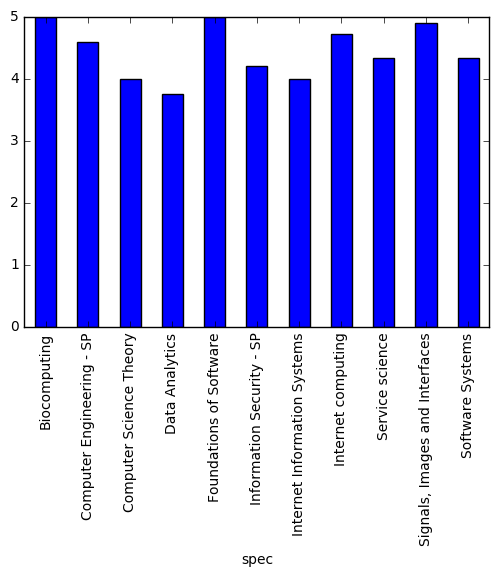

In [213]:
%matplotlib inline
grouped.mean().semester_count.plot(kind='bar')

### Discussion:

For each specialization `s`, we will compare `s.mean` and the general average for people having a specialization.<br><br>
For each test, the null hypothesis we are testing against is: <b style="color:orange">H0 = "The average duration for the stay at EPFL when chosing this specialization is not statistically different from the general average"</b>.<br>
We will use the <b>one-sample t-test</b> for proving or disproving this hypothesis.<br>

In [239]:
print('The p-values for each specialization are:')
for s_name, s_data in grouped:
    if len(s_data) > 1:
        print(s_name, ':   ', stats.ttest_1samp(
            s_data.semester_count,
            students_with_spec.semester_count.mean()
        ).pvalue)

The p-values for each specialization are:
Biocomputing :    0.825247690928
Computer Engineering - SP :    0.588504064409
Data Analytics :    0.0304544538648
Foundations of Software :    0.0718541658505
Information Security - SP :    0.0605590749374
Internet computing :    0.997508703962
Service science :    0.367389431899
Signals, Images and Interfaces :    0.442939194729
Software Systems :    0.00854234618811


So specializations "Data analytics" and "software sytems", which have a p-value lower than 5%, **satistfy H0**, that is, their average length is not statistically different from the general average.<br>
The average length of **all other** specializations (whose p-values are > 5%) **are statistically different**